# Librerías a emplear

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [4]:
df_train = pd.read_csv('train.csv') # Data set para entrenar el modelo

In [5]:
df_train.shape # Número de filas y columnas

(891, 12)

## Información de las variables.

* PassengerId: Número identificador único asignado a cada pasajero.
* Survived:  Indica si el pasajero sobrevivió al hundimiento del Titanic
* Pclass: 1= Primera clase / 2= Segunda clase / 3= Tercera clase.
* Name: Nombre del pasajero.
* Sex: Sexo del pasajero.
* Age: Edad del pasajero.
* SibSp: SibSp: Número de familiares directos a bordo, como hermanos o cónyuges.
* Parch: Número de padres o hijos del pasajero que también estaban a bordo.
* Ticket: Número del billete comprado por el pasajero.
* Fare: Precio del billete pagado (en libras esterlinas).
* Cabin: Código de la cabina asignada al pasajero.  
* Embarked: Puerto (C = Cherburgo, Q = Queenstown, S = Southampton).

# Análisis

## Estadísticos principales

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df_train.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df_train.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


## Visualización

In [9]:
def vis(dataset):
    for var in dataset.columns.difference(["PassengerId","Name","Cabin","Ticket"]):
        if dataset[var].dtype == 'int64' or dataset[var].dtype == 'float64':
          fig = px.histogram(dataset, x=var)
          fig.show()
        else:
          fig = px.histogram(dataset, x=var)
          fig.show()

vis(df_train)


Vemos que existe un ligero desbalance en la variable objetivo **Survived**. Observamos que la mayoría de los pasajeros se encontraban en el rango de 18 a 40 años, y que la asistencia predominante fue de varones. La mayoría de los pasajeros embarcaron en el puerto de Southampton, una gran parte de ellos de manera individual (sin acompañantes) y, en su mayoría, pagando un boleto de 15 libras esterlinas. Esto podría explicar el desbalance hacia la tercera clase en la categoría de clases.

## Valores nulos

In [10]:
df_train.apply(lambda x: x.isnull().sum()/len(df_train)*100)

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


In [11]:
# Relación de las columnas com nans y la variable objetivo
fig = px.box(df_train, y="Age", x="Pclass")
fig.show()

fig = px.box(df_train, y="Age", x="Survived")
fig.show()

Se observa que las variables **Age, Cabin, Embarked** tienen valores nulos. Las dos primeras son las más preocupantes, en especial **Cabin**, que tiene más de 75% de valores perdidos.  
Descartaremos la variable **Cabin** y emplearemos la imputación por moda en la variable **Embarked** y la imputación por mediana en la variable **Age**.  

In [12]:
# Imputamos la variable Age
df_train.loc[(df_train['Age'].isna()) & (df_train['Pclass'] == 1), "Age"] = df_train.groupby(["Pclass"]).Age.median()[1]
df_train.loc[(df_train['Age'].isna()) & (df_train['Pclass'] == 2), "Age"] = df_train.groupby(["Pclass"]).Age.median()[2]
df_train.loc[(df_train['Age'].isna()) & (df_train['Pclass'] == 3), "Age"] = df_train.groupby(["Pclass"]).Age.median()[3]

# Imputamos la variable Embarked
df_train.loc[df_train['Embarked'].isna(), 'Embarked'] = df_train.Embarked.mode()[0]

In [13]:
df_train.drop('Cabin',axis=1,inplace=True)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


## Cardinalidad

In [15]:
for col in df_train:
  print(f"La variable {col} tiene {df_train[col].nunique()} valores únicos")

La variable PassengerId tiene 891 valores únicos
La variable Survived tiene 2 valores únicos
La variable Pclass tiene 3 valores únicos
La variable Name tiene 891 valores únicos
La variable Sex tiene 2 valores únicos
La variable Age tiene 88 valores únicos
La variable SibSp tiene 7 valores únicos
La variable Parch tiene 7 valores únicos
La variable Ticket tiene 681 valores únicos
La variable Fare tiene 248 valores únicos
La variable Embarked tiene 3 valores únicos


Se buscará reducir el número de categorías de las columna **Name**. Revisando está columna, se observa que a los nombres de cada pasajero los procede un título (Lady, Cptn, etc.). Se extraerá los títulos para crear una nueva columna llamada **Title** y así eliminar la columna **Name**.

In [16]:
df_train['Title'] = df_train.Name.str.extract('([A-Za-z]+)\.',expand=False)
df_train['Title'].value_counts()

,count
Title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2


Vamos a reducir la cantidad total de categorías

In [17]:
df_train["Title"] = df_train["Title"].replace({
    'Mme': 'Mrs',
    'Ms': 'Miss',
    'Don': 'Mr',
    'Mlle': 'Miss',
    'Lady': 'Miss',
    'Dr': 'Mr',
    'Rev': 'Mr',
    'Major': 'Mr',
    'Sir': 'Mr',
    'Capt': 'Mr',
    'Jonkheer': 'Mr',
    'Countess': 'Mrs',
    'Col': 'Mr'
})


In [18]:
df_train['Title'].value_counts()

,count
Title,
Mr,538
Miss,186
Mrs,127
Master,40


In [19]:
df_train.drop(["Ticket","Name"],inplace=True,axis=1)

## Convertir todas las variables a númericas

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [21]:
df_train.Embarked.value_counts()

,count
Embarked,
S,646
C,168
Q,77


In [22]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S,Mr
887,888,1,1,female,19.0,0,0,30.0000,S,Miss
888,889,0,3,female,24.0,1,2,23.4500,S,Miss
889,890,1,1,male,26.0,0,0,30.0000,C,Mr


In [23]:
#Convertimos las variables a dummies

##Embarked##
puertos = pd.get_dummies(df_train["Embarked"],columns=["Embarked"], prefix="Embarked", drop_first=False)
df_train = pd.concat([df_train,puertos],axis=1) # Unimos los dos dfs
df_train.drop("Embarked",inplace=True,axis=1) # Eliminamos la columna Embarked

df_train["Embarked_C"] = df_train["Embarked_C"].apply(lambda x: 1 if x == True else 0)
df_train["Embarked_Q"] = df_train["Embarked_Q"].apply(lambda x: 1 if x == True else 0)
df_train["Embarked_S"] = df_train["Embarked_S"].apply(lambda x: 1 if x == True else 0)

##Sex##
df_train["Sex"] = df_train["Sex"].map({"female":1, "male":0})

##Title##
df_train["Title"] = df_train["Title"].map({"Mr":0, "Mrs":1, "Miss":2, "Master":3})

df_train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,0,0,0,1
1,2,1,1,1,38.0,1,0,71.2833,1,1,0,0


## Outliers

Vamos a empezar por analizar las asimetrías

In [24]:
df_train.select_dtypes(include=np.number).apply(lambda x: x.skew())

,0
PassengerId,0.000000
Survived,0.478523
Pclass,-0.630548
Sex,0.618921
Age,0.548256
SibSp,3.695352
Parch,2.749117
Fare,4.787317
Title,0.958784
Embarked_C,1.595149


Se observan que las columnas **SibSp, Parch y Fare** presentan una alta asimetría (valor absoluto mayor a 0). Podemos tratar con las dos primeras a futuro, ya que, como son categorías, podemos disminuir el número de estas. Con **Fare**, al observar su distribución, se decide aplicar una transformación logarítmica para disminuir la dispersión de los datos.

In [25]:
# Transformamos la variable Fare
df_train["Fare"] = np.log1p(df_train.Fare)

# Observamos su asimetría
df_train.Fare.skew()

np.float64(0.3949280095189306)

Se puede observar que la asimetría de la columna **Fare** se redució por más de dos unidades. Ahora, analizaremos el porcentaje de valores atípicos dentro del conjunto de datos

In [26]:
def winsorize_with_pandas(s, limits):
    """
    s : pd.Series
        Series to winsorize
    limits : tuple of float
        Tuple of the percentages to cut on each side of the array,
        with respect to the number of unmasked data, as floats between 0. and 1
    """
    return s.clip(lower=s.quantile(limits[0], interpolation='lower'),
                  upper=s.quantile(1 - limits[1], interpolation='higher'))

def gestiona_outliers(col, clas='check'):
    print(col.name)
    # Condición de asimetría y aplicación de criterio 1 según el caso
    if abs(col.skew()) < 1:
        criterio1 = abs((col - col.mean()) / col.std()) > 3
    else:
        criterio1 = abs((col - col.median()) / stats.median_abs_deviation(col)) > 8

    # Calcular primer cuartil
    q1 = col.quantile(0.25)
    # Calcular tercer cuartil
    q3 = col.quantile(0.75)
    # Calculo de IQR
    IQR = q3 - q1
    # Calcular criterio 2 (general para cualquier asimetría)
    criterio2 = (col < (q1 - 3 * IQR)) | (col > (q3 + 3 * IQR))
    lower = col[criterio1 & criterio2 & (col < q1)].count() / col.dropna().count()
    upper = col[criterio1 & criterio2 & (col > q3)].count() / col.dropna().count()
    # Salida según el tipo deseado
    if clas == 'check':
        return lower * 100, upper * 100, (lower + upper) * 100
    elif clas == 'winsor':
        return winsorize_with_pandas(col, (lower, upper))
    elif clas == 'miss':
        print('\n MissingAntes: ' + str(col.isna().sum()))
        col.loc[criterio1 & criterio2] = np.nan
        print('MissingDespues: ' + str(col.isna().sum()) + '\n')
        return col

# Llamada en modo check
df_train.select_dtypes(include=np.number).copy().apply(lambda x: gestiona_outliers(x))


PassengerId
Survived
Pclass
Sex
Age
SibSp
Parch
Fare
Title
Embarked_C
Embarked_Q
Embarked_S


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,1.346801,23.905724,0.0,0.0,18.855219,8.641975,0.0
2,0.0,0.0,0.0,0.0,0.0,1.346801,23.905724,0.0,0.0,18.855219,8.641975,0.0


Ignorando las variables dummies, se observa que **SibSp y Parch**, tienen presencia de outliers, donde la situación es más crítica con la segunda variable. Pero, al ser variables categorícas, a futuro se agruparán categorías para reducir la variabilidad.

# Modelado

## Empleando un modelo con todos los predictores

In [27]:
# Realizo la partición del data set
df_train.set_index('PassengerId', inplace=True)
y = df_train["Survived"]
X = df_train.drop("Survived", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=99)

In [28]:
# Comprobé el balance de la variable objetivo
y_test.mean(), y_train.mean()

(np.float64(0.3687150837988827), np.float64(0.38764044943820225))

In [29]:
# Creé el modelo
modelo = RandomForestClassifier(random_state=99)
modelo.fit(X_train,y_train)

RandomForestClassifier(random_state=99)

In [30]:
# Predicción
y_pred_test = modelo.predict(X_test)
precision = accuracy_score(y_test,y_pred_test)
precision

0.8379888268156425

Se realizo la predicción con aproximadamente un 80% de éxito

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       113
           1       0.78      0.77      0.78        66

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



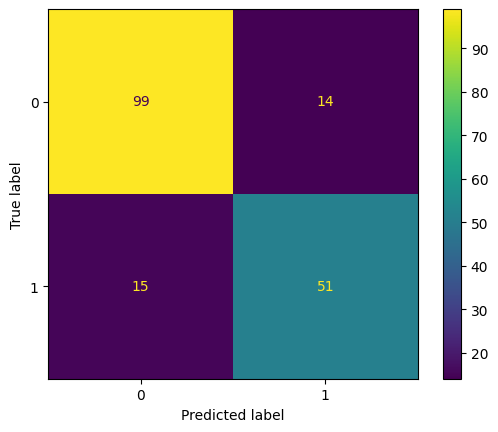

In [31]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
print(classification_report(y_test, y_pred_test))

Sensibilidad: La sensibilidad, que es el valor de los 1s correctamente predecidos entre el total de 1s es de aproximadamente 73%.
Especificidad: La especificidad, que es el valor de los 0s correctamente predecidos entre el total de 0s es de aproximadamente 84%.  
Como decisión, buscaré aumentar la sensibilidad a costo de "sacrificar" la especificidad.


## Importancia/peso de los predictores empleados

In [32]:
# Peso de los modelos
importancia_caracteristicas = modelo.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
importancia_df = pd.DataFrame({
    'Predictor': X.columns,
    'Importancia': importancia_caracteristicas
}).sort_values(by='Importancia', ascending=False)

# Plotear la importancia de las características
fig = px.bar(data_frame=importancia_df,x='Predictor', y='Importancia')
fig.update_layout(title='Importancia de las Características')
fig.show()

In [33]:
importancia_df[:5].sum()

,0
Predictor,FareAgeTitleSexPclass
Importancia,0.888557


Seleccionaremos los predictores **Fare,Age,Title,Sex,Pclass** pues, la suma del peso de estas cinco representan aproximadamente el 87% del modelo. Esto se hace para evitar el sobreajuste y para reducir el ruido.

## Colinealidad
Vamos a evaluar si existe colinealidad, para eso emplearemos la métrica VIF (Variance Inflation Factor).

In [34]:
vif = pd.DataFrame()
vif["predictores"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
vif

,predictores,VIF
0,Pclass,2.610545
1,Sex,2.196956
2,Age,1.603223
3,SibSp,1.541340
4,Parch,1.427819
5,Fare,2.789784
6,Title,2.801179
7,Embarked_C,18.322984
8,Embarked_Q,9.446870
9,Embarked_S,64.982563


Vemos que tenemos 11 predictores, de los cuales solo se tiene un VIF elevado para la variable dummie Embarked, lo cual era esperable. De todas maneras, estas columnas seran descartadas, debido a que la "importancia" que tienen en el modelo es minima.

## Modelo 2
Creamos un nuevo modelo con el nuevo conjunto de predictores reducido

In [35]:
X = X.drop(["SibSp","Parch","Embarked_C","Embarked_Q","Embarked_S"],axis=1)
X.head(2)

,Pclass,Sex,Age,Fare,Title
PassengerId,,,,,
1,3,0,22.0,2.110213,0
2,1,1,38.0,4.280593,1


In [36]:
# Realizamos una nueva partición del nuevo conjunto X
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=99)

In [37]:
y_train.mean(),y_test.mean()

(np.float64(0.38764044943820225), np.float64(0.3687150837988827))

In [38]:
modelo = RandomForestClassifier(random_state=99)
modelo.fit(X_train,y_train)

RandomForestClassifier(random_state=99)

In [39]:
ypred = modelo.predict(X_test)
accuracy_score(y_test,ypred)

0.7932960893854749

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       113
           1       0.71      0.74      0.73        66

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.80      0.79      0.79       179



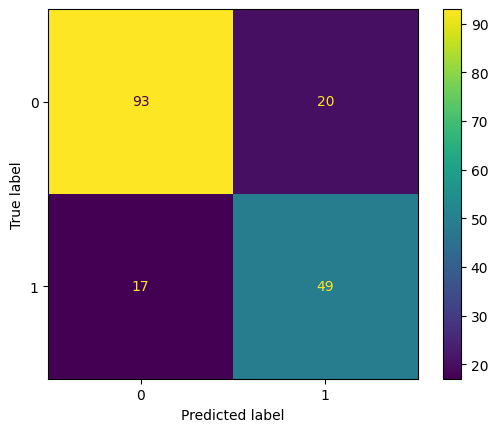

In [40]:
# Matriz de confusión
cm = confusion_matrix(y_test, ypred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
print(classification_report(y_test, ypred))

Vemos cierta mejora en las métricas del modelo. Ahora, buscaremos si se puede mejorar aún más el modelo mediante el "tuning" de parámetros.

In [41]:
# Definir el espacio de búsqueda de hiperparámetros para el Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar el Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el rendimiento
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"Mejor precisión obtenida: {grid_search.best_score_:.2f}")

Mejores parámetros encontrados:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mejor precisión obtenida: 0.84


Ahora, volvemos a modelar con estos nuevos parametros y solo faltaría predecir el conjunto de test (previas modificaciones, pues debemos transformar algunas columnas).

In [42]:
modelo = RandomForestClassifier(random_state=99, max_depth=10, min_samples_leaf=1, min_samples_split=5,n_estimators=50)
modelo.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=50,
                       random_state=99)

In [43]:
ypred = modelo.predict(X_test)
accuracy_score(y_test,ypred)

0.8268156424581006

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       113
           1       0.77      0.76      0.76        66

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



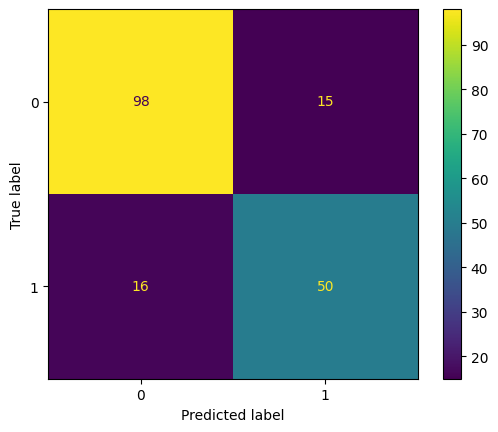

In [44]:
# Matriz de confusión
cm = confusion_matrix(y_test, ypred)
cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
print(classification_report(y_test, ypred))

## Predicción
Una vez ya tenemos el modelo listo, lo empleamos para predecir el conjunto test.

In [45]:
# Cargamos el dataset de test
df_test = pd.read_csv("test.csv")
df_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Las columnas **Age, Fare, title, Pclass, Sex** son las más importantes para el modelo. Las demás columnas nos son irrelevantes. Por lo qué se deben hacer las modificaciones necesarias. Por otro lado, tambien debemos transformar la columna **Fare**. Además, tenemos na's, por lo cual debemos imputar.

In [47]:
df_test['Title'] = df_test.Name.str.extract('([A-Za-z]+)\.',expand=False)
df_test['Title'].value_counts()

,count
Title,
Mr,240
Miss,78
Mrs,72
Master,21
Col,2
Rev,2
Ms,1
Dr,1
Dona,1


In [48]:
#Extración de titulos de los nombres y creación de title
df_test['Title'] = df_test.Name.str.extract('([A-Za-z]+)\.',expand=False)
df_test["Title"] = df_test["Title"].replace({
    'Mme': 'Mrs',
    'Dona': 'Mrs', # Nuevo item
    'Ms': 'Miss',
    'Don': 'Mr',
    'Mlle': 'Miss',
    'Lady': 'Miss',
    'Dr': 'Mr',
    'Rev': 'Mr',
    'Major': 'Mr',
    'Sir': 'Mr',
    'Capt': 'Mr',
    'Jonkheer': 'Mr',
    'Countess': 'Mrs',
    'Col': 'Mr'
})

##Sex##
df_test["Sex"] = df_test["Sex"].map({"female":1, "male":0})

##Title##
df_test["Title"] = df_test["Title"].map({"Mr":0, "Mrs":1, "Miss":2, "Master":3})

##Imputación de Age##
df_test.loc[(df_test['Age'].isna()) & (df_test['Pclass'] == 1), "Age"] = df_test.groupby(["Pclass"]).Age.median()[1]
df_test.loc[(df_test['Age'].isna()) & (df_test['Pclass'] == 2), "Age"] = df_test.groupby(["Pclass"]).Age.median()[2]
df_test.loc[(df_test['Age'].isna()) & (df_test['Pclass'] == 3), "Age"] = df_test.groupby(["Pclass"]).Age.median()[3]

#Imputación de Fare##
df_test.loc[df_test.Fare.isna(), "Fare"] = df_test.groupby("Embarked").Fare.mean()["S"]

#Transformación de Fare
df_test["Fare"] = np.log1p(df_test["Fare"])

df_test.set_index("PassengerId",inplace=True)

In [49]:
#Eliminamos las columnas innecesarias
df_test.drop(["Name", "SibSp", "Parch", "Ticket", "Cabin", "Embarked"],axis=1,inplace=True)

In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    int64  
 2   Age     418 non-null    float64
 3   Fare    418 non-null    float64
 4   Title   418 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 19.6 KB


In [51]:
predicciones_test = modelo.predict(df_test)

In [52]:
index = df_test.index
predicciones = pd.DataFrame(data=predicciones_test,columns=["Survived"], index=index)

In [53]:
predicciones # Obtengo el DataFrame de las predicciones

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Inicializar el modelo Random Forest
# Realizar validación cruzada con 5 folds
scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')

# Mostrar los resultados de la validación cruzada
print(f"Precisión promedio de validación cruzada: {scores.mean():.2f}")
print(f"Desviación estándar de validación cruzada: {scores.std():.2f}")


Precisión promedio de validación cruzada: 0.84
Desviación estándar de validación cruzada: 0.02


# Conclusión
- Se obtiene un accuracy de 0.83, es decir que se producen correcta un 83% de todos los items, por lo cual la tasa de error es de 17%. Por otro lado, tenemos una sensibilidad de 76%, una precisión de 77% y una especificidad de 87%. Además, tenemos un F1-score (media armónica entre la sensibilidad y la precisión) de 76%. La tasa de falsos positivos es de aproximadamente 13% y la tasa de falsos positivos es de 24%.
- El modelo determino que cinco variables eran las más adecuadas para realizar la predicción: **Pclass, Sex, Age, Title, Fare**.
